In [50]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

#Tries to enable dynamic memory allocation on GP
try:
	for i in tensorflow.config.experimental.list_physical_devices("GPU"):
		tensorflow.config.experimental.set_memory_growth(i, True)
except:
	print("Device dynamic memory allocation failed!")


Device dynamic memory allocation failed!


In [69]:
class PrunnableLSTMCell(layers.LSTMCell):
    """Custom LSTM Class for prunning weights"""
    def __init__(self, *args, **kwargs):
        super(PrunnableLSTMCell, self).__init__(*args, **kwargs)
        
        self.trainable_channels = None
        self.trainable_recurrent_channels = None
        self.trainable_bias = None
        
        self._kernel1 = None
        self._kernel2 = None
        
        self._recurrent_kernel1 = None
        self._recurrent_kernel2 = None
        
        self._bias1 = None
        self._bias2 = None
        
        self.saved_W = None
        self.saved_recW = None
        self.saved_bias = None
        
    def build(self, input_shape):
        input_dim = input_shape[-1]

        if type(self.recurrent_initializer).__name__ == 'Identity':
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self._kernel1 = self.add_weight(shape=(input_dim, self.units * 4),name='kernel',
                                        initializer=self.kernel_initializer,
                                        regularizer=self.kernel_regularizer,
                                        constraint=self.kernel_constraint)
        
        self.recurrent_kernel1 = self.add_weight(
                                        shape=(self.units, self.units * 4),
                                        name='recurrent_kernel',
                                        initializer=self.recurrent_initializer,
                                        regularizer=self.recurrent_regularizer,
                                        constraint=self.recurrent_constraint)
        
        self.trainable_channels = tensorflow.ones((input_dim, self.units*4), dtype=tensorflow.uint8)
        self.trainable_recurrent_channels = tensorflow.ones((input_dim, self.units*4), dtype=tensorflow.uint8)
        
        self._kernel2 = tensorflow.zeros((input_dim, self.units*4))
        self._recurrent_kernel2 = tensorflow.zeros((input_dim, self.units*4))
        
        
        if self.use_bias:
            if self.unit_forget_bias:
                @K.eager
                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        initializers.Ones()((self.units,), *args, **kwargs),
                        self.bias_initializer((self.units * 2,), *args, **kwargs),
                    ])
            else:
                bias_initializer = self.bias_initializer
            self._bias1 = self.add_weight(shape=(self.units * 4,),      #inicializa bias1
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            self._bias2 = tensorflow.zeros((self.units * 4,))     #inicializa bias2
        else:
            self._bias1 = None

        self._kernel1_i = self._kernel1[:, :self.units]
        self._kernel1_f = self._kernel1[:, self.units: self.units * 2]
        self._kernel1_c = self._kernel1[:, self.units * 2: self.units * 3]
        self._kernel1_o = self._kernel1[:, self.units * 3:]

        self.recurrent_kernel_i = self.recurrent_kernel[:, :self.units]
        self.recurrent_kernel_f = (self.recurrent_kernel[:, self.units: self.units * 2])
        self.recurrent_kernel_c = (self.recurrent_kernel[:, self.units * 2: self.units * 3])
        self.recurrent_kernel_o = self.recurrent_kernel[:, self.units * 3:]

        if self.use_bias:
            self._bias1_i = self._bias1[:self.units]
            self._bias1_f = self._bias1[self.units: self.units * 2]
            self._bias1_c = self._bias1[self.units * 2: self.units * 3]
            self._bias1_o = self._bias1[self.units * 3:]
        else:
            self._bias1_i = None
            self._bias1_f = None
            self._bias1_c = None
            self._bias1_o = None
        self.built = True
    
    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=4)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=4)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state

        if self.implementation == 1:
            if 0 < self.dropout < 1.:
                inputs_i = inputs * dp_mask[0]
                inputs_f = inputs * dp_mask[1]
                inputs_c = inputs * dp_mask[2]
                inputs_o = inputs * dp_mask[3]
            else:
                inputs_i = inputs
                inputs_f = inputs
                inputs_c = inputs
                inputs_o = inputs
            x_i = K.dot(inputs_i, self.kernel_i)
            x_f = K.dot(inputs_f, self.kernel_f)
            x_c = K.dot(inputs_c, self.kernel_c)
            x_o = K.dot(inputs_o, self.kernel_o)
            if self.use_bias:
                x_i = K.bias_add(x_i, self.bias_i)
                x_f = K.bias_add(x_f, self.bias_f)
                x_c = K.bias_add(x_c, self.bias_c)
                x_o = K.bias_add(x_o, self.bias_o)

            if 0 < self.recurrent_dropout < 1.:
                h_tm1_i = h_tm1 * rec_dp_mask[0]
                h_tm1_f = h_tm1 * rec_dp_mask[1]
                h_tm1_c = h_tm1 * rec_dp_mask[2]
                h_tm1_o = h_tm1 * rec_dp_mask[3]
            else:
                h_tm1_i = h_tm1
                h_tm1_f = h_tm1
                h_tm1_c = h_tm1
                h_tm1_o = h_tm1
            i = self.recurrent_activation(x_i + K.dot(h_tm1_i,
                                                      self.recurrent_kernel_i))
            f = self.recurrent_activation(x_f + K.dot(h_tm1_f,
                                                      self.recurrent_kernel_f))
            c = f * c_tm1 + i * self.activation(x_c + K.dot(h_tm1_c,
                                                            self.recurrent_kernel_c))
            o = self.recurrent_activation(x_o + K.dot(h_tm1_o,
                                                      self.recurrent_kernel_o))
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]
            z = K.dot(inputs, self.kernel)
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]
            z += K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                z = K.bias_add(z, self.bias)

            z0 = z[:, :self.units]
            z1 = z[:, self.units: 2 * self.units]
            z2 = z[:, 2 * self.units: 3 * self.units]
            z3 = z[:, 3 * self.units:]

            i = self.recurrent_activation(z0)
            f = self.recurrent_activation(z1)
            c = f * c_tm1 + i * self.activation(z2)
            o = self.recurrent_activation(z3)

        h = o * self.activation(c)
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, [h, c]
        

In [52]:

df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [53]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [54]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [55]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


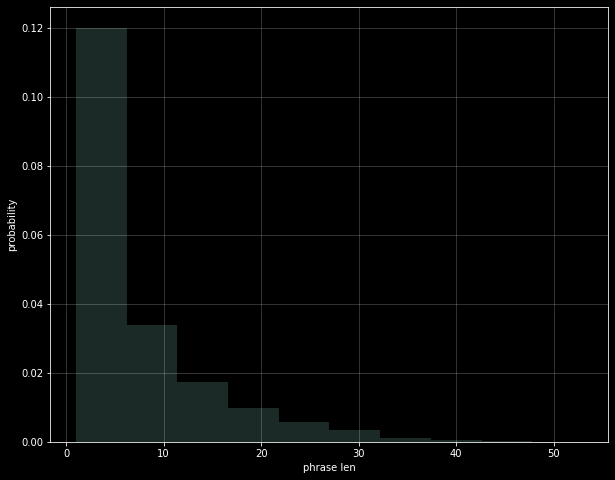

In [56]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [57]:
y_train = df_train['Sentiment']

In [58]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [59]:
batch_size = 512
epochs = 8

lstm = LSTM(2, dropout = 0.3, recurrent_dropout = 0.3)

In [60]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 2, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(lstm)
model_lstm.add(Dense(2, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 53, 2)             16384     
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 53, 2)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15        
Total params: 16,445
Trainable params: 16,445
Non-trainable params: 0
__________________________________________________

In [61]:
for l in model_lstm.layers:
    print (l.name ,l.input_shape,l.output_shape)

embedding_7 (None, 53) (None, 53, 2)
spatial_dropout1d_7 (None, 53, 2) (None, 53, 2)
lstm_4 (None, 53, 2) (None, 2)
dense_9 (None, 2) (None, 2)
dropout_5 (None, 2) (None, 2)
dense_10 (None, 2) (None, 5)


In [65]:
lstm.get_weights()

[array([[-0.06526989,  0.73098266,  0.216492  , -0.4776182 ,  0.15904027,
         -0.52829576, -0.4858962 ,  0.7484752 ],
        [ 0.49711823,  0.01280099,  0.46655333, -0.48079225, -0.02107787,
          0.67949593,  0.04307991,  0.17732894]], dtype=float32),
 array([[-0.27657878,  0.73275286,  0.16077298,  0.14454499,  0.5197249 ,
          0.09078886, -0.24794883, -0.00101149],
        [-0.48607293, -0.05828494, -0.16193764,  0.44474727, -0.04847855,
          0.3184467 ,  0.5376616 ,  0.37877905]], dtype=float32),
 array([0., 0., 1., 1., 0., 0., 0., 0.], dtype=float32)]

In [66]:
lstm.weights

[<tf.Variable 'lstm_4/kernel:0' shape=(2, 8) dtype=float32>,
 <tf.Variable 'lstm_4/recurrent_kernel:0' shape=(2, 8) dtype=float32>,
 <tf.Variable 'lstm_4/bias:0' shape=(8,) dtype=float32>]

In [36]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Train on 140454 samples, validate on 15606 samples
Epoch 1/8
  3584/140454 [..............................] - ETA: 3:03 - loss: 1.4535 - accuracy: 0.4464

KeyboardInterrupt: 

In [45]:
model_lstm.layers[2].get_weights()

[array([[-0.02968112,  0.03597156, -0.01354118, ..., -0.03768282,
         -0.04530798, -0.02483854],
        [ 0.05838573,  0.05833712,  0.00812168, ...,  0.05591835,
         -0.05493913,  0.01831878],
        [-0.04771251, -0.05766204, -0.06676204, ..., -0.00069349,
         -0.02751125,  0.02011073],
        ...,
        [ 0.05549449, -0.00820057,  0.00711385, ..., -0.0414844 ,
          0.00168291,  0.00126061],
        [-0.03992298,  0.02788351,  0.06319727, ..., -0.00913438,
         -0.00883676, -0.03685146],
        [-0.02418134, -0.00530547, -0.01863088, ...,  0.01666331,
          0.00479218,  0.05247296]], dtype=float32),
 array([[-0.01685544, -0.03643855,  0.03491455, ..., -0.03796409,
          0.00122   , -0.00635956],
        [ 0.01097   ,  0.00624066, -0.02087489, ..., -0.00792929,
          0.04014329,  0.01911935],
        [-0.00103643, -0.02223545,  0.01245315, ..., -0.01563763,
          0.02655006, -0.0246109 ],
        ...,
        [ 0.01397585, -0.03611711, -0.0